# HW8: Geostatistics

You are tasked with mapping Cadmium (Cd) contamination in agricultural soils. Cadmium is a highly toxic element that is found in fertilizers. Soil is considered to be toxic or unsafe for agriculture when Cd measurements exceed 6 mg/kg. Sparse Cd measurements were gathered across a region. Your goal is to interpolate these measurements in order to estimate soil quality for the entire area. You will work with a sample data set containing columns with X and Y coordinates in km, and Cd concentration in terms of mg/kg.

The goal of this assignment is to model variograms and perform kriging and SGS interpolation on a Cd contamination data set.
  

1. Perform a normal score transformation. Plot the histogram before and after transformation to show that the transformed data has a standard Gaussian distribution. [1 point]

2. Compute the isotropic experimental variogram for the transformed data using Scikit GStat. Use a maximum lag distance of 100 km. [2 point]

3. Fit an exponential variogram model to the experimental variogram using Scikit GStat. What is the lag and range? Plot the variogram model on top of your experimental variogram. [1 point]

4. Perform a kriging interpolation. Choose reasonable parameters for k (the number of nearest neighbor conditioning points to use) and the search radius. The kriging interpolation may take a few minutes to run. Back transform the data to recover the original data distribution. Plot the estimate and standard deviation. What percentage of this area is considered to have unsafe Cd levels? [3 points]

5. Perform a sequential Gaussian simulation. Generate 3 realizations. Plot the results. What percentage of each of these areas have unsafe Cd levels? Which method do you think has better local accuracy? Which method is better at estimating the total percentage with unsafe Cd? [3 points]

This Jupyter Book will be useful: https://gatorglaciology.github.io/gstatsimbook/intro.html

In [ ]:
# install packages
!pip install -q gstatsim
!pip install -q scikit-gstat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from sklearn.preprocessing import QuantileTransformer
import gstatsim as gs
import skgstat as skg
from skgstat import models
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 KB 9.9 MB/s eta 0:00:00


<function matplotlib.pyplot.show(close=None, block=None)>

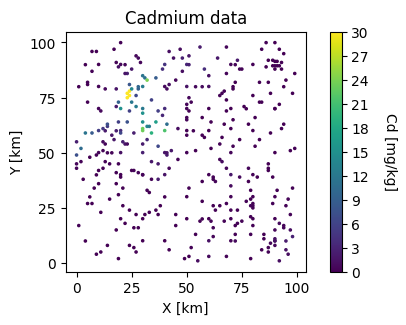

In [ ]:
# load and plot data
df = pd.read_csv("https://raw.githubusercontent.com/GatorGlaciology/Intro-to-ML-course/main/HW8_data.csv") # load the data from Dr. Pyrcz's GitHub repository

fig = plt.figure()
im = plt.scatter(df['X'],df['Y'], c = df['Cd'], vmin = 0, vmax = 30, marker=".", s = 10) # scatter plot for location map
plt.title('Cadmium data')                                    # add plot title
plt.xlabel('X [km]'); plt.ylabel('Y [km]')
plt.locator_params(nbins=5)# set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(0, 30, 11)) # add vertical color bar
cbar.set_label("Cd [mg/kg]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.5) # adjust the plot size
plt.axis('scaled')
plt.show

1. Perform a normal score transformation. Plot the histogram before and after transformation to show that the transformed data has a standard Gaussian distribution. [1 point]

In [ ]:
df

,Unnamed: 0.1,Unnamed: 0,X,Y,Cd,NCd
0,0,0,10.0,90.0,0.049922,-0.765794
1,1,1,10.0,80.0,0.267795,0.020283
2,2,2,10.0,70.0,0.445454,0.335156
3,3,3,10.0,60.0,5.427734,1.220333
4,4,4,10.0,50.0,0.417934,0.281623
...,...,...,...,...,...,...
363,363,363,31.0,21.9,0.010851,-1.717685
364,364,364,62.0,15.9,0.436141,0.322736
365,365,365,2.0,45.9,0.290628,0.082436
366,366,366,65.0,46.9,0.477468,0.380374


<function matplotlib.pyplot.show(close=None, block=None)>

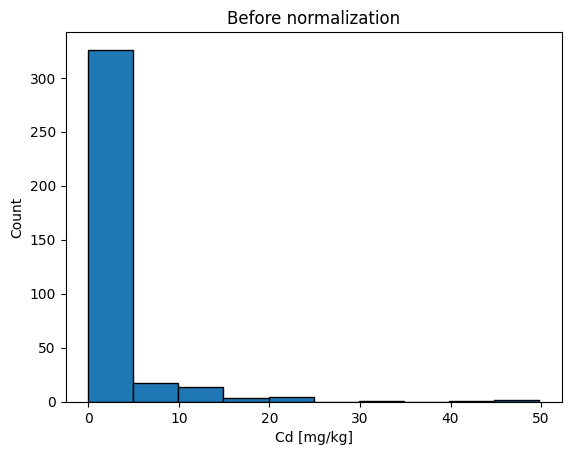

In [ ]:
hist_reg = plt.hist(df.Cd, edgecolor= 'black')
plt.title("Before normalization")
plt.xlabel("Cd [mg/kg]")
plt.ylabel("Count")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

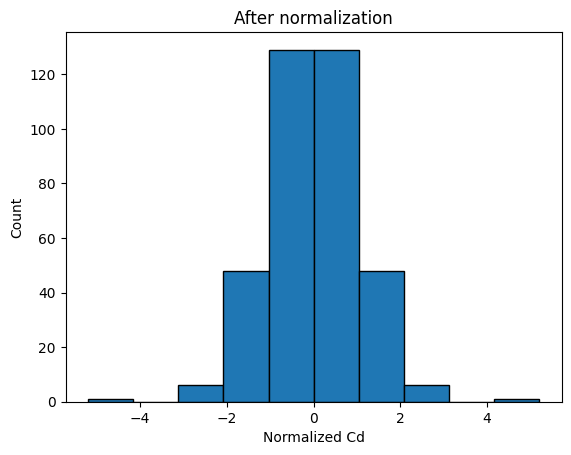

In [ ]:
data = df['Cd'].values.reshape(-1, 1)
nst_trans = QuantileTransformer(n_quantiles=368, output_distribution="normal").fit(data)
df['NCd'] = nst_trans.transform(data)
hist_norm = plt.hist(df['NCd'], edgecolor= 'black')
plt.title("After normalization")
plt.xlabel("Normalized Cd")
plt.ylabel("Count")
plt.show

2. Compute the isotropic experimental variogram for the transformed data using Scikit GStat. Use a maximum lag distance of 100 km. [2 point]

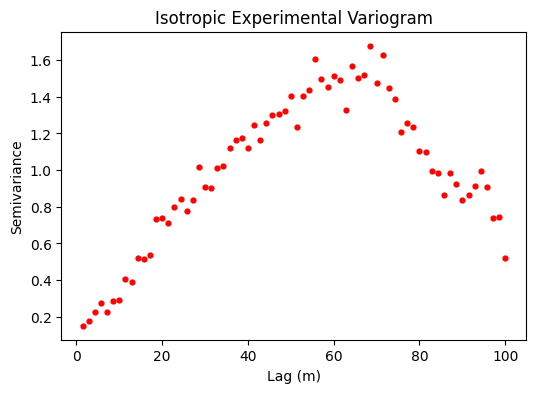

In [ ]:
coords = df[['X', 'Y']].values
values = df['NCd']
VS = skg.Variogram(coordinates=coords, values=values, bin_func='even', n_lags=70, maxlag=100, normalize=False)
xdata = VS.bins
ydata = VS.experimental

plt.figure(figsize=(6, 4))
plt.scatter(xdata, ydata, s=12, c='r')
plt.title("Isotropic Experimental Variogram")
plt.xlabel("Lag (m)")
plt.ylabel("Semivariance")
plt.show()

3. Fit an exponential variogram model to the experimental variogram using Scikit GStat. What is the lag and range? Plot the variogram model on top of your experimental variogram. [1 point]

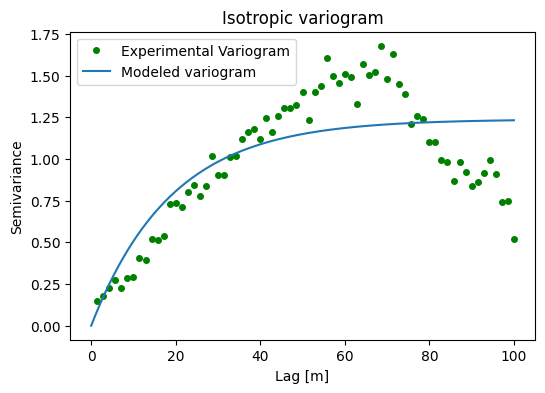

In [ ]:
VS.model = 'exponential'
vrange = VS.parameters[0]
vsill = VS.parameters[1]
vnugget = VS.parameters[2]
xi = np.linspace(0, xdata[-1], 1000)
y_exp = [models.exponential(h, vrange, vsill, vnugget) for h in xi]

plt.figure(figsize=(6, 4))
plt.plot(xdata, ydata, 'og', markersize=4, label = "Experimental Variogram")
plt.plot(xi, y_exp, '-', label= "Modeled variogram")
plt.title("Isotropic variogram")
plt.xlabel("Lag [m]")
plt.ylabel("Semivariance")
plt.legend(loc= "upper left")
plt.show()

In [ ]:
print(f"Range: {vrange}")
print(f"Sill: {vsill}")

Range: 56.95418326224985
Sill: 1.2384162827362413


4. Perform a kriging interpolation. Choose reasonable parameters for k (the number of nearest neighbor conditioning points to use) and the search radius. The kriging interpolation may take a few minutes to run. Back transform the data to recover the original data distribution. Plot the estimate and standard deviation. What percentage of this area is considered to have unsafe Cd levels? [3 points]

In [ ]:
# 4 Kriging interpolation
Pred_grid_xy = gs.Gridding.prediction_grid(0, 100, 0, 100, 1) # define coordinate grid with min and max of 0 and 100 km, and a resolution of 1 km

In [ ]:
##### kriging interpolation here #######
azimuth = 0
vario = [azimuth, vnugget, vrange, vrange, vsill]

k = 50 # number of nearest neighbor conditioning data points
rad = 10 # 10 km search radius

# est_5K is the estimate and var_SK is the variance
est_SK, var_SK = gs.Interpolation.skrige(Pred_grid_xy, df, 'X', 'Y', 'NCd', k, vario, rad)

100%|██████████| 10201/10201 [01:45<00:00, 97.04it/s]


In [ ]:
# reverse normal score transformation (assuming est_SK and var_SK are the names of the kriging estimate and variance outputs)
var_SK[var_SK < 0] = 0      # make sure variances are non-negative
std_SK = np.sqrt(var_SK)    # convert to standard deviation before back transforming

# reshape
est = est_SK.reshape(-1,1)
std = std_SK.reshape(-1,1)

# back transformation
spred_trans = nst_trans.inverse_transform(est)
sstd_trans = nst_trans.inverse_transform(std)
sstd_trans = sstd_trans - np.min(sstd_trans)

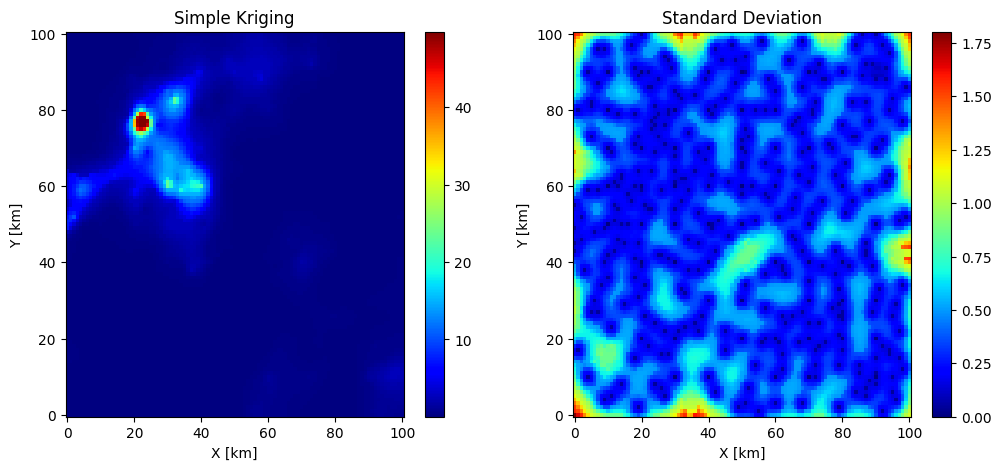

In [ ]:
X = Pred_grid_xy[:, 0].reshape((101,101))
Y = Pred_grid_xy[:, 1].reshape((101, 101))

fig, axs = plt.subplots(1, 2, figsize=(12,5))
image1 = axs[0].pcolormesh(X, Y, spred_trans.reshape((101,101)), cmap='jet')
axs[0].set_title('Simple Kriging')
axs[0].set_xlabel('X [km]')
axs[0].set_ylabel('Y [km]')

image2 = axs[1].pcolormesh(X, Y, sstd_trans.reshape((101, 101)), cmap = 'jet')
axs[1].set_title('Standard Deviation')
axs[1].set_xlabel('X [km]')
axs[1].set_ylabel('Y [km]')

fig.colorbar(image1, ax=axs[0])
fig.colorbar(image2, ax=axs[1])

plt.show()

In [ ]:
thresh = 6
unsafe = (spred_trans > thresh).sum() / spred_trans.size * 100
print(f"{unsafe:.2f}% of the area is considered to have unsafe Cd levels.")

5.74% of the area is considered to have unsafe Cd levels.


5. Perform a sequential Gaussian simulation. Generate 3 realizations. Plot the results. What percentage of each of these areas have unsafe Cd levels? Which method do you think has better local accuracy? Which method is better at estimating the total percentage with unsafe Cd? [3 points]

In [ ]:
sim1 = gs.Interpolation.skrige_sgs(Pred_grid_xy, df, 'X', 'Y', 'NCd', k, vario, rad)
# reverse normal score transformation
sim1_1 = sim1.reshape((-1, 1))
sim1_trans = nst_trans.inverse_transform(sim1_1)

100%|██████████| 10201/10201 [02:04<00:00, 82.16it/s]


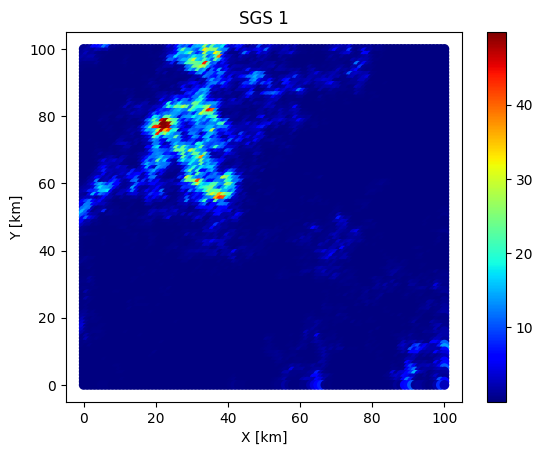

In [ ]:
plt.scatter(Pred_grid_xy[:, 0], Pred_grid_xy[:, 1], c=sim1_trans, cmap='jet')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('SGS 1')
plt.colorbar()

In [ ]:
sim2 = gs.Interpolation.skrige_sgs(Pred_grid_xy, df, 'X', 'Y', 'NCd', k, vario, rad)
# reverse normal score transformation
sim2_1 = sim1.reshape((-1, 1))
sim2_trans = nst_trans.inverse_transform(sim2_1)

100%|██████████| 10201/10201 [02:13<00:00, 76.56it/s]


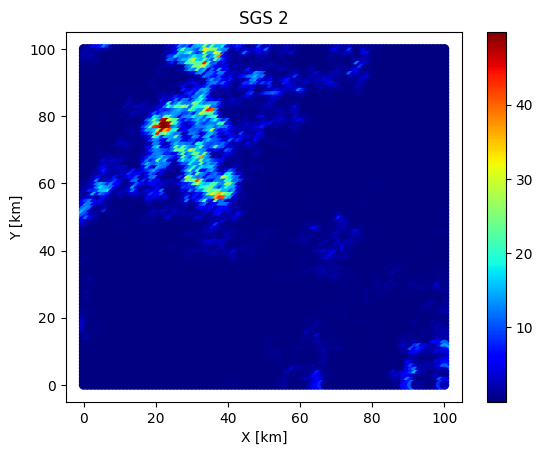

In [ ]:
plt.scatter(Pred_grid_xy[:, 0], Pred_grid_xy[:, 1], c=sim2_trans, cmap='jet')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('SGS 2')
plt.colorbar()

In [ ]:
sim3 = gs.Interpolation.skrige_sgs(Pred_grid_xy, df, 'X', 'Y', 'NCd', k, vario, rad)
# reverse normal score transformation
sim3_1 = sim1.reshape((-1, 1))
sim3_trans = nst_trans.inverse_transform(sim3_1)

100%|██████████| 10201/10201 [02:12<00:00, 76.84it/s]


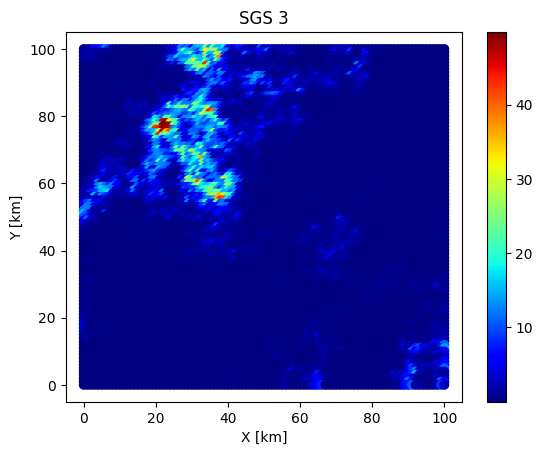

In [ ]:
plt.scatter(Pred_grid_xy[:, 0], Pred_grid_xy[:, 1], c=sim3_trans, cmap='jet')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('SGS 3')
plt.colorbar()

In [ ]:
thresh = 6
unsafe1 = (sim1_trans > thresh).sum() / len(sim1_trans) * 100
print(f"{unsafe1}% of the area from SGS 1 is considered to have unsafe Cd levels.")
unsafe2 = (sim2_trans > thresh).sum() / len(sim2_trans) * 100
print(f"{unsafe2}% of the area from SGS 2 is considered to have unsafe Cd levels.")
unsafe3 = (sim3_trans > thresh).sum() / len(sim3_trans) * 100
print(f"{unsafe3}% of the area from SGS 3 is considered to have unsafe Cd levels.")

7.979609842172336% of the area from SGS 1 is considered to have unsafe Cd levels.
7.979609842172336% of the area from SGS 2 is considered to have unsafe Cd levels.
7.979609842172336% of the area from SGS 3 is considered to have unsafe Cd levels.


Kriging seems to have better local accuracy, but SGS appears to be better at estimating the total percentage of area with unsafe Cd levels. Of the initial given data, 10% of the Cd values were greater than 6, which is closer to the estimate from SGS than from kriging.